<a href="https://colab.research.google.com/github/rachit-shah/ADBI-projects/blob/master/Copy_of_Neural_Network_F2_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import pickle

# Data Generator

In [0]:
import os
import tensorflow as tf

from tensorflow.python.data.experimental import AUTOTUNE

In [0]:
class DIV2K:
    def __init__(self,
                 scale=2,
                 subset='train',
                 downgrade='bicubic',
                 images_dir='.div2k/images',
                 caches_dir='.div2k/caches'):

        self._ntire_2018 = True

        _scales = [2, 3, 4, 8]

        if scale in _scales:
            self.scale = scale
        else:
            raise ValueError(f'scale must be in ${_scales}')

        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        _downgrades_a = ['bicubic', 'unknown']
        _downgrades_b = ['mild', 'difficult']

        if scale == 8 and downgrade != 'bicubic':
            raise ValueError(f'scale 8 only allowed for bicubic downgrade')

        if downgrade in _downgrades_b and scale != 4:
            raise ValueError(f'{downgrade} downgrade requires scale 4')

        if downgrade == 'bicubic' and scale == 8:
            self.downgrade = 'x8'
        elif downgrade in _downgrades_b:
            self.downgrade = downgrade
        else:
            self.downgrade = downgrade
            self._ntire_2018 = False

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        if not os.path.exists(self._hr_images_dir()):
            download_archive(self._hr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._hr_image_files()).cache(self._hr_cache_file())

        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        return ds

    def lr_dataset(self):
        if not os.path.exists(self._lr_images_dir()):
            download_archive(self._lr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._lr_image_files()).cache(self._lr_cache_file())

        if not os.path.exists(self._lr_cache_index()):
            self._populate_cache(ds, self._lr_cache_file())

        return ds

    def _hr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_HR.cache')

    def _lr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def _hr_cache_index(self):
        return f'{self._hr_cache_file()}.index'

    def _lr_cache_index(self):
        return f'{self._lr_cache_file()}.index'

    def _hr_image_files(self):
        images_dir = self._hr_images_dir()
        return [os.path.join(images_dir, f'{image_id:04}.png') for image_id in self.image_ids]

    def _lr_image_files(self):
        images_dir = self._lr_images_dir()
        return [os.path.join(images_dir, self._lr_image_file(image_id)) for image_id in self.image_ids]

    def _lr_image_file(self, image_id):
        if not self._ntire_2018 or self.scale == 8:
            return f'{image_id:04}x{self.scale}.png'
        else:
            return f'{image_id:04}x{self.scale}{self.downgrade[0]}.png'

    def _hr_images_dir(self):
        return os.path.join(self.images_dir, f'DIV2K_{self.subset}_HR')

    def _lr_images_dir(self):
        if self._ntire_2018:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}')
        else:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}', f'X{self.scale}')

    def _hr_images_archive(self):
        return f'DIV2K_{self.subset}_HR.zip'

    def _lr_images_archive(self):
        if self._ntire_2018:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}.zip'
        else:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.zip'

    @staticmethod
    def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


# -----------------------------------------------------------
#  Transformations
# -----------------------------------------------------------


def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)


# -----------------------------------------------------------
#  IO
# -----------------------------------------------------------


def download_archive(file, target_dir, extract=True):
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))

In [0]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='unknown')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='unknown')

In [10]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

208961536/208956781 [==============================] - 11s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_unknown_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_unknown_X4.cache.
3530604544/3530603713 [==============================] - 180s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
26697728/26695095 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_unknown_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_unknown_X4.cache.
448995328/448993893 [==============================] - 24s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


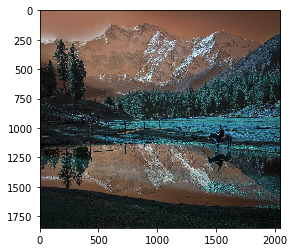

In [29]:
plt.imshow(cv2.imread('.div2k/images/DIV2K_train_HR/0002.png'))

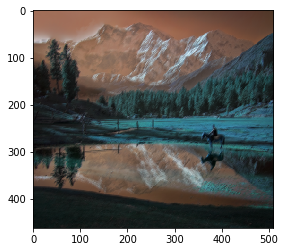

In [28]:
plt.imshow(cv2.imread('.div2k/images/DIV2K_train_LR_unknown/X4/0002x4.png'))

# Evaluation (PSNR)

In [0]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

In [0]:
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)


# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5


# ---------------------------------------
#  Metrics
# ---------------------------------------


def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)


# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


In [0]:
def evaluate_psnr(groundtruth,pred):
  #return -10. * np.log10(np.mean(np.square(pred - groundtruth)))
  #return tf.image.psnr(groundtruth, pred, max_val=255)
  max_pixel = 1.0
  return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(pred - groundtruth), axis=-1)))) / 2.303

# Model

In [0]:
import time
import tensorflow as tf

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

In [0]:
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model

In [0]:
#source: https://github.com/twairball/keras-subpixel-conv
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)


    return Lambda(subpixel, output_shape=subpixel_shape)

In [0]:
def simple_cnn(scale=4,num_filters=64):
  x_in = Input(shape=(None, None, 3))
  x = Lambda(normalize,name="normalize")(x_in)

  x = Conv2D(num_filters, 3, padding='same')(x)
  x = Conv2D(num_filters, 3, padding='same')(x)
  
  #upsample
  x = Conv2D(256, 3, padding='same')(x)
  x = SubpixelConv2D(input_shape=x.shape,scale=2)(x)
  x = Activation('relu')(x)

  x = Conv2D(256, 3, padding='same')(x)
  x = SubpixelConv2D(input_shape=x.shape,scale=2)(x)
  x = Activation('relu')(x)

  x = Conv2D(3, 3, padding='same')(x)
  x = Lambda(denormalize,name="denormalize")(x)
  return Model(x_in, x, name="simple_cnn")

In [0]:
cnn_model = simple_cnn()

In [177]:
cnn_model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
normalize (Lambda)           (None, None, None, 3)     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, None, None, 256)   147712    
_________________________________________________________________
lambda_13 (Lambda)           (None, None, None, 64)    0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, None, None, 256)   1

In [0]:
class Trainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/cnn'):

        self.now = None
        self.loss = loss
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              optimizer=Adam(learning_rate),
                                              model=model)
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_dir,
                                                             max_to_keep=3)

        self.restore()

    @property
    def model(self):
        return self.checkpoint.model

    def train(self, train_dataset, valid_dataset, steps, evaluate_every=1000, save_best_only=False):
        loss_mean = Mean()

        ckpt_mgr = self.checkpoint_manager
        ckpt = self.checkpoint

        self.now = time.perf_counter()

        for lr, hr in train_dataset.take(steps - ckpt.step.numpy()):
            ckpt.step.assign_add(1)
            step = ckpt.step.numpy()

            loss = self.train_step(lr, hr)
            loss_mean(loss)

            if step % evaluate_every == 0:
                loss_value = loss_mean.result()
                loss_mean.reset_states()

                # Compute PSNR on validation dataset
                psnr_value = self.evaluate(valid_dataset)

                duration = time.perf_counter() - self.now
                print(f'{step}/{steps}: loss = {loss_value.numpy():.3f}, PSNR = {psnr_value.numpy():3f} ({duration:.2f}s)')

                if save_best_only and psnr_value <= ckpt.psnr:
                    self.now = time.perf_counter()
                    # skip saving checkpoint, no PSNR improvement
                    continue

                ckpt.psnr = psnr_value
                ckpt_mgr.save()

                self.now = time.perf_counter()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.checkpoint.model(lr, training=True)
            loss_value = self.loss(hr, sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return loss_value

    def evaluate(self, dataset):
        return evaluate(self.checkpoint.model, dataset)

    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')

In [0]:
learning_rate=0.0001
checkpoint_dir='./ckpt/cnn'
loss=MeanAbsoluteError()
steps=5000
evaluate_every=steps%100
save_best_only=True

In [195]:
cnnTrainer = Trainer(model=cnn_model,checkpoint_dir=checkpoint_dir,learning_rate=learning_rate,loss=loss)

Model restored from checkpoint at step 1026.


In [196]:
cnnTrainer.train(train_ds,valid_ds,steps,evaluate_every,save_best_only)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in remainder


1027/5000: loss = 11.173, PSNR = 21.106833 (1.42s)
1028/5000: loss = 15.167, PSNR = 21.035519 (0.58s)
1029/5000: loss = 10.627, PSNR = 22.865980 (0.57s)
1030/5000: loss = 14.594, PSNR = 22.381077 (0.58s)
1031/5000: loss = 15.960, PSNR = 21.303440 (0.58s)
1032/5000: loss = 13.619, PSNR = 21.886213 (0.59s)
1033/5000: loss = 14.468, PSNR = 21.577169 (0.58s)
1034/5000: loss = 9.807, PSNR = 21.400402 (0.59s)
1035/5000: loss = 14.421, PSNR = 24.155043 (0.58s)
1036/5000: loss = 15.421, PSNR = 25.209185 (0.57s)
1037/5000: loss = 12.803, PSNR = 19.013784 (0.58s)
1038/5000: loss = 16.171, PSNR = 21.516310 (0.60s)
1039/5000: loss = 13.852, PSNR = 22.667734 (0.57s)
1040/5000: loss = 14.389, PSNR = 22.775305 (0.59s)
1041/5000: loss = 15.202, PSNR = 23.511225 (0.58s)
1042/5000: loss = 10.411, PSNR = 20.094858 (0.58s)
1043/5000: loss = 7.934, PSNR = 20.435701 (0.58s)
1044/5000: loss = 15.876, PSNR = 21.957626 (0.59s)
1045/5000: loss = 14.521, PSNR = 26.027311 (0.61s)
1046/5000: loss = 14.341, PSNR = 

# Predict

In [0]:
from PIL import Image

In [0]:
def load_image(path):
    return cv2.imread(path)

In [0]:
def plot_sample(lr, sr, hr,psnrLR=None,psnrSR=None):
    plt.figure(figsize=(20, 10))

    images = [lr, sr, hr]
    titles = ['LR', 'SR', 'HR']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        if title == 'LR':
          lrupscale = cv2.resize(img,(img.shape[1]*4,img.shape[0]*4))
          im = Image.fromarray(lrupscale)
          im.save(title+'-UP.png')
        im = Image.fromarray(img)
        im.save(title+'.png')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        if title == 'LR':
          plt.xlabel('PSNR: '+str(round(psnrLR.numpy(),2))+'dB')
        if title == 'SR':
          plt.xlabel('PSNR: '+str(round(psnrSR.numpy(),2))+'dB')

In [0]:
def resolve_and_plot(lr_image_path,hr_image_path):
    lr = load_image(lr_image_path)
    print(lr.shape)
    lr_tensor = tf.convert_to_tensor(np.array([lr]),dtype=tf.float32)
    lrupscale = cv2.resize(lr,(lr.shape[1]*4,lr.shape[0]*4))
    lrupscale_tensor = tf.convert_to_tensor(np.array([lrupscale]),dtype=tf.float32)
    print(lr_tensor.shape)
    sr_tensor = resolve(cnn_model,lr_tensor)[0]
    sr = sr_tensor.numpy()
    hr = load_image(hr_image_path)
    hr_tensor = tf.convert_to_tensor(np.array([hr]),dtype=tf.float32)
    psnrSR = psnr(hr_tensor, sr_tensor)[0]
    psnrLR = psnr(hr_tensor, lrupscale_tensor)[0]
    print(hr.shape)
    plot_sample(lr, sr, hr,psnrLR,psnrSR)

(339, 510, 3)
(1, 339, 510, 3)
(1356, 2040, 3)


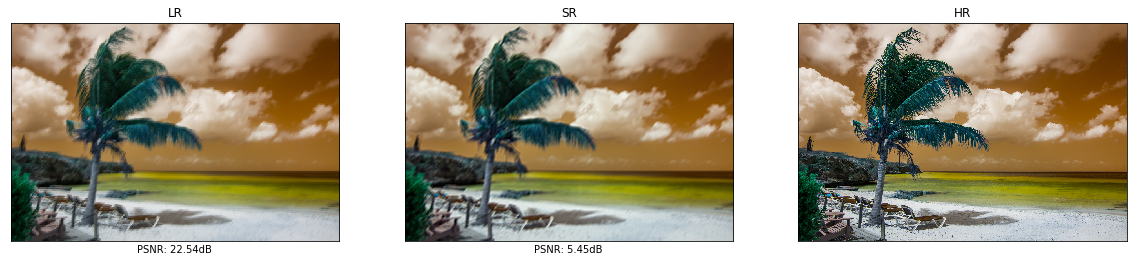

In [189]:
resolve_and_plot('.div2k/images/DIV2K_valid_LR_unknown/X4/0806x4.png','.div2k/images/DIV2K_valid_HR/0806.png')

(411, 510, 3)
(1, 411, 510, 3)
(1644, 2040, 3)


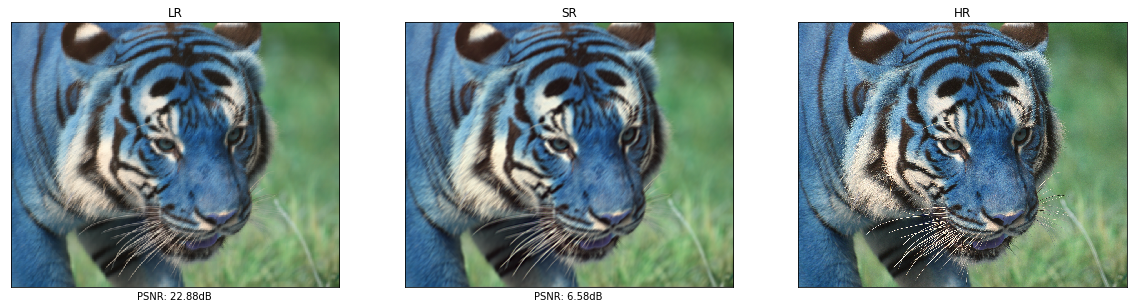

In [190]:
resolve_and_plot('.div2k/images/DIV2K_train_LR_unknown/X4/0010x4.png','.div2k/images/DIV2K_train_HR/0010.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

In [164]:
!ls

ckpt	HR.png	LR-UP.png    SR.png	 trainY.pkl  validY.pkl
gdrive	LR.png	sample_data  trainX.pkl  validX.pkl


In [0]:
!cp -r ckpt gdrive/My\ Drive/SR/CNN

In [0]:
cnn_model.save_weights('cnn_5000.h5')

In [0]:
!cp cnn_5000.h5 gdrive/My\ Drive/SR/CNN